# Experiment 1: OOD Detection

In this experiment, we evaluate the ensembles approach on the task of OOD detection. We compare it with the approaches of: the Baseline of Hendrycks et al., the ODIN detector, and the Mahanalobis detector.

### Imports

In [1]:
# sklearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# torch
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# own modules
import densenet
import resnet
import utils.dnn_utils as dnn_utils
import utils.experiment_utils as exp_utils
import utils.ensemble_utils as ens_utils
import utils.metrics as metrics
import utils.plots as myplots

## Setting

We run the experiments below using the same setting of the Mahanalobis paper. We use their pretrained Neural Nets, one Densenet and one Resnet, and use the same In-Distribution (IND) and Out-Of-Distribution (OOD) datasets and preprocessings. We test the setting where approaches don't have access to OOD data for hyperparameter tuning. Finally, below we evaluate only our approach; the results of the other approaches can be found on the Mahanalobis paper, and reproduced running the official code.

A quick summary of our approach is shown in the image below. Basically, we extract the features of the penultimate layer, and apply a small ensemble on top. Then, we use the ensemble members to estimate the uncertainty of some new input, using the predictions entropy.

![title](figs/approach.png)

## Experiment 1: CIFAR 10 (IND) vs SVHN on Densenet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [2]:
# load the model
pre_trained_net = 'models/densenet_cifar10.pth'
model = torch.load(pre_trained_net)
# fix model (due to previous torch version)
dnn_utils.fix_model(model)
# put model in eval mode
model.eval()

# some extra params
batch_size = 100
n_classes = 10
layer_sizes_mean = [24, 108, 150, 342, n_classes]
# normalization transform for that model
min_pixel = -1.98888885975
max_pixel = 2.12560367584
norm_trans_std = (63.0/255, 62.1/255.0, 66.7/255.0) 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),])

C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseNet3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dum

### Load datasets

Then, we load the IND and OOD datasets

In [3]:
# load In-Distribution (IND) data
# CIFAR 10
trainset = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# SVHN
testset = datasets.SVHN(root='data', split='test',
                                       download=True, transform=transform)
ood_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [5]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)


 13%|██████████▊                                                                      | 67/500 [01:09<07:28,  1.04s/it]


 27%|█████████████████████▌                                                          | 135/500 [02:20<06:19,  1.04s/it]


 41%|████████████████████████████████▍                                               | 203/500 [03:30<05:07,  1.04s/it]


 54%|███████████████████████████████████████████▎                                    | 271/500 [04:41<03:55,  1.03s/it]


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [05:51<02:48,  1.04s/it]


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [07:01<01:36,  1.03s/it]


 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [08:12<00:25,  1.03s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [08:38<00:00,  1.04s/it]

 10%|████████                                                                         | 10/100 [00:10<01:33,  1.04s/it]

  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

  0%|▎                                                                                 | 1/261 [00:01<04:24,  1.02s/it]

  1%|▋                                                                                 | 2/261 [00:02<04:26,  1.03s/it]

  1%|▉                                                                                 | 3/261 [00:03<04:26,  1.03s/it]

  2%|█▎                                                                                | 4/261 [00:04<04:24,  1.03s/it]

  2%|█▌                                                                                | 5/261 [00:05<04:24,  1.03s/it]

  2%|█▉                         

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [18]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 10%|████████▎                                                                          | 1/10 [00:02<00:26,  2.95s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



 20%|████████████████▌                                                                  | 2/10 [00:05<00:22,  2.86s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Opt

TypeError: cannot unpack non-iterable NoneType object

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

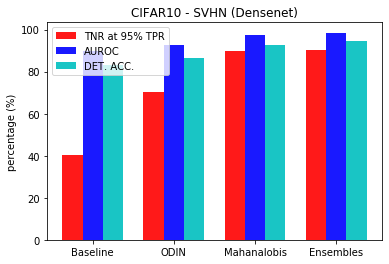

In [19]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (40.2, 70.5, 89.6, 100 * tnr_at_tpr95)
AUROC_ALL = (89.9, 92.8, 97.6, 100 * auroc)
DTACC_ALL = (83.2, 86.5, 92.6, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'CIFAR10 - SVHN (Densenet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])

## Experiment 2: CIFAR 100 (IND) vs LSUN on Densenet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [2]:
# load the model
pre_trained_net = 'models/densenet_cifar100.pth'
model = torch.load(pre_trained_net)
# fix model (due to previous torch version)
dnn_utils.fix_model(model)
# put model in eval mode
model.eval()

# some extra params
batch_size = 100
n_classes = 100
layer_sizes_mean = [24, 108, 150, 342, n_classes]
# normalization transform for that model
min_pixel = -1.98888885975
max_pixel = 2.12560367584
norm_trans_std = (63.0/255, 62.1/255.0, 66.7/255.0) 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),])


C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseNet3' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\admin\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'densenet.DenseBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dum

### Load datasets

Then, we load the IND and OOD datasets

In [3]:
# load In-Distribution (IND) data
# CIFAR100
trainset = datasets.CIFAR100(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR100(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# LSUN
testset = ImageFolder(root='data/LSUN_resize',  transform = transform)

ood_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [4]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)

 10%|████████                                                                         | 10/100 [00:17<02:39,  1.77s/it]

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [5]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 10%|████████▎                                                                          | 1/10 [00:06<00:56,  6.24s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


 20%|████████████████▌                                                                  | 2/10 [00:12<00:49,  6.22s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimi

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

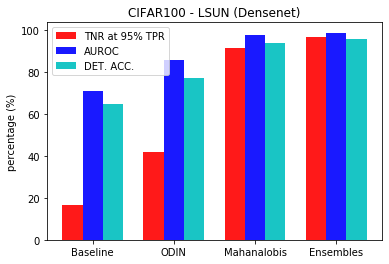

In [6]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (16.7, 42.1, 91.4, 100 * tnr_at_tpr95)
AUROC_ALL = (70.8, 85.7, 97.9, 100 * auroc)
DTACC_ALL = (64.9, 77.3, 93.8, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'CIFAR100 - LSUN (Densenet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])

## Experiment 3: SVHN (IND) vs TINY IMAGENET on Densenet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [7]:
# load the model
pre_trained_net = 'models/densenet_svhn.pth'
device = 'cuda'
n_classes = 10
model = densenet.DenseNet3(100, int(n_classes)).to(device)
model.load_state_dict(torch.load(pre_trained_net, map_location = 'cuda'))
# set model to eval mode
model.eval()

# some extra params
batch_size = 100
layer_sizes_mean = [24, 108, 150, 342, n_classes]
# normalization transform for that model
min_pixel = -1.98888885975
max_pixel = 2.12560367584
norm_trans_std = (63.0/255, 62.1/255.0, 66.7/255.0) 
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0)),])


### Load datasets

Then, we load the IND and OOD datasets

In [8]:
# load In-Distribution (IND) data
# SVHN
trainset = datasets.SVHN(root='data', split='train',
                                       download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

testset = datasets.SVHN(root='data', split='test',
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# TINY IMGNET
ood_test_data = ImageFolder(root='data/Imagenet_resize',  transform = transform)

ood_test_loader = torch.utils.data.DataLoader(ood_test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [9]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)



  0%|                                                                                          | 0/733 [00:00<?, ?it/s]

  0%|                                                                                  | 1/733 [00:01<16:10,  1.33s/it]

  0%|▏                                                                                 | 2/733 [00:02<15:06,  1.24s/it]

  0%|▎                                                                                 | 3/733 [00:03<14:20,  1.18s/it]

  1%|▍                                                                                 | 4/733 [00:04<13:47,  1.14s/it]

  1%|▌                                                                                 | 5/733 [00:05<13:27,  1.11s/it]

  1%|▋                                                                                 | 6/733 [00:06<13:13,  1.09s/it]

  1%|▊                                                                                 | 7/733 [00:07<13:05,  1.08s/it]

  1%|▉                        

  9%|███████▍                                                                         | 67/733 [01:10<11:36,  1.05s/it]

  9%|███████▌                                                                         | 68/733 [01:11<11:34,  1.04s/it]

  9%|███████▌                                                                         | 69/733 [01:12<11:31,  1.04s/it]

 10%|███████▋                                                                         | 70/733 [01:13<11:32,  1.04s/it]

 10%|███████▊                                                                         | 71/733 [01:14<11:30,  1.04s/it]

 10%|███████▉                                                                         | 72/733 [01:15<11:33,  1.05s/it]

 10%|████████                                                                         | 73/733 [01:16<11:35,  1.05s/it]

 10%|████████▏                                                                        | 74/733 [01:17<11:39,  1.06s/it]

 10%|████████▎                  

 18%|██████████████▌                                                                 | 134/733 [02:20<10:24,  1.04s/it]

 18%|██████████████▋                                                                 | 135/733 [02:21<10:23,  1.04s/it]

 19%|██████████████▊                                                                 | 136/733 [02:22<10:23,  1.04s/it]

 19%|██████████████▉                                                                 | 137/733 [02:23<10:21,  1.04s/it]

 19%|███████████████                                                                 | 138/733 [02:24<10:22,  1.05s/it]

 19%|███████████████▏                                                                | 139/733 [02:25<10:19,  1.04s/it]

 19%|███████████████▎                                                                | 140/733 [02:26<10:20,  1.05s/it]

 19%|███████████████▍                                                                | 141/733 [02:27<10:17,  1.04s/it]

 19%|███████████████▍           

 27%|█████████████████████▉                                                          | 201/733 [03:30<09:16,  1.05s/it]

 28%|██████████████████████                                                          | 202/733 [03:31<09:16,  1.05s/it]

 28%|██████████████████████▏                                                         | 203/733 [03:32<09:15,  1.05s/it]

 28%|██████████████████████▎                                                         | 204/733 [03:33<09:14,  1.05s/it]

 28%|██████████████████████▎                                                         | 205/733 [03:34<09:12,  1.05s/it]

 28%|██████████████████████▍                                                         | 206/733 [03:35<09:11,  1.05s/it]

 28%|██████████████████████▌                                                         | 207/733 [03:37<09:11,  1.05s/it]

 28%|██████████████████████▋                                                         | 208/733 [03:38<09:10,  1.05s/it]

 29%|██████████████████████▊    

 37%|█████████████████████████████▏                                                  | 268/733 [04:40<08:05,  1.04s/it]

 37%|█████████████████████████████▎                                                  | 269/733 [04:41<08:03,  1.04s/it]

 37%|█████████████████████████████▍                                                  | 270/733 [04:42<08:02,  1.04s/it]

 37%|█████████████████████████████▌                                                  | 271/733 [04:43<08:01,  1.04s/it]

 37%|█████████████████████████████▋                                                  | 272/733 [04:45<07:59,  1.04s/it]

 37%|█████████████████████████████▊                                                  | 273/733 [04:46<07:58,  1.04s/it]

 37%|█████████████████████████████▉                                                  | 274/733 [04:47<07:58,  1.04s/it]

 38%|██████████████████████████████                                                  | 275/733 [04:48<07:57,  1.04s/it]

 38%|███████████████████████████

 46%|████████████████████████████████████▌                                           | 335/733 [05:50<06:58,  1.05s/it]

 46%|████████████████████████████████████▋                                           | 336/733 [05:51<06:58,  1.05s/it]

 46%|████████████████████████████████████▊                                           | 337/733 [05:52<06:56,  1.05s/it]

 46%|████████████████████████████████████▉                                           | 338/733 [05:53<06:56,  1.05s/it]

 46%|████████████████████████████████████▉                                           | 339/733 [05:55<06:54,  1.05s/it]

 46%|█████████████████████████████████████                                           | 340/733 [05:56<06:53,  1.05s/it]

 47%|█████████████████████████████████████▏                                          | 341/733 [05:57<06:51,  1.05s/it]

 47%|█████████████████████████████████████▎                                          | 342/733 [05:58<06:51,  1.05s/it]

 47%|███████████████████████████

 55%|███████████████████████████████████████████▊                                    | 402/733 [07:01<05:46,  1.05s/it]

 55%|███████████████████████████████████████████▉                                    | 403/733 [07:02<05:45,  1.05s/it]

 55%|████████████████████████████████████████████                                    | 404/733 [07:03<05:42,  1.04s/it]

 55%|████████████████████████████████████████████▏                                   | 405/733 [07:04<05:41,  1.04s/it]

 55%|████████████████████████████████████████████▎                                   | 406/733 [07:05<05:41,  1.04s/it]

 56%|████████████████████████████████████████████▍                                   | 407/733 [07:06<05:39,  1.04s/it]

 56%|████████████████████████████████████████████▌                                   | 408/733 [07:07<05:38,  1.04s/it]

 56%|████████████████████████████████████████████▋                                   | 409/733 [07:08<05:37,  1.04s/it]

 56%|███████████████████████████

 64%|███████████████████████████████████████████████████▏                            | 469/733 [08:11<04:37,  1.05s/it]

 64%|███████████████████████████████████████████████████▎                            | 470/733 [08:12<04:36,  1.05s/it]

 64%|███████████████████████████████████████████████████▍                            | 471/733 [08:13<04:35,  1.05s/it]

 64%|███████████████████████████████████████████████████▌                            | 472/733 [08:14<04:34,  1.05s/it]

 65%|███████████████████████████████████████████████████▌                            | 473/733 [08:15<04:32,  1.05s/it]

 65%|███████████████████████████████████████████████████▋                            | 474/733 [08:16<04:32,  1.05s/it]

 65%|███████████████████████████████████████████████████▊                            | 475/733 [08:17<04:30,  1.05s/it]

 65%|███████████████████████████████████████████████████▉                            | 476/733 [08:18<04:29,  1.05s/it]

 65%|███████████████████████████

 73%|██████████████████████████████████████████████████████████▍                     | 536/733 [09:21<03:25,  1.04s/it]

 73%|██████████████████████████████████████████████████████████▌                     | 537/733 [09:22<03:23,  1.04s/it]

 73%|██████████████████████████████████████████████████████████▋                     | 538/733 [09:23<03:23,  1.04s/it]

 74%|██████████████████████████████████████████████████████████▊                     | 539/733 [09:24<03:22,  1.04s/it]

 74%|██████████████████████████████████████████████████████████▉                     | 540/733 [09:25<03:21,  1.04s/it]

 74%|███████████████████████████████████████████████████████████                     | 541/733 [09:26<03:20,  1.04s/it]

 74%|███████████████████████████████████████████████████████████▏                    | 542/733 [09:27<03:19,  1.04s/it]

 74%|███████████████████████████████████████████████████████████▎                    | 543/733 [09:28<03:17,  1.04s/it]

 74%|███████████████████████████

 82%|█████████████████████████████████████████████████████████████████▊              | 603/733 [10:31<02:16,  1.05s/it]

 82%|█████████████████████████████████████████████████████████████████▉              | 604/733 [10:32<02:15,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████              | 605/733 [10:33<02:14,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████▏             | 606/733 [10:34<02:13,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████▏             | 607/733 [10:35<02:12,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████▎             | 608/733 [10:36<02:10,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████▍             | 609/733 [10:37<02:09,  1.05s/it]

 83%|██████████████████████████████████████████████████████████████████▌             | 610/733 [10:38<02:08,  1.05s/it]

 83%|███████████████████████████

 91%|█████████████████████████████████████████████████████████████████████████       | 670/733 [11:41<01:05,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 671/733 [11:42<01:04,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▎      | 672/733 [11:43<01:03,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 673/733 [11:44<01:02,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 674/733 [11:45<01:01,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 675/733 [11:46<01:00,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 676/733 [11:47<00:59,  1.04s/it]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 677/733 [11:48<00:58,  1.04s/it]

 92%|███████████████████████████

  1%|▉                                                                                 | 3/261 [00:03<04:29,  1.04s/it]

  2%|█▎                                                                                | 4/261 [00:04<04:27,  1.04s/it]

  2%|█▌                                                                                | 5/261 [00:05<04:28,  1.05s/it]

  2%|█▉                                                                                | 6/261 [00:06<04:26,  1.05s/it]

  3%|██▏                                                                               | 7/261 [00:07<04:25,  1.05s/it]

  3%|██▌                                                                               | 8/261 [00:08<04:24,  1.05s/it]

  3%|██▊                                                                               | 9/261 [00:09<04:23,  1.05s/it]

  4%|███                                                                              | 10/261 [00:10<04:23,  1.05s/it]


  0%|                          

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [10]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)




 10%|████████▎                                                                          | 1/10 [00:05<00:46,  5.18s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)




 20%|████████████████▌                                                                  | 2/10 [00:10<00:41,  5.14s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic 

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

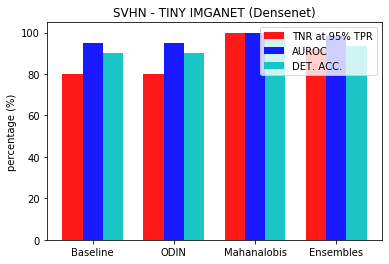

In [11]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (79.8, 79.8, 99.9, 100 * tnr_at_tpr95)
AUROC_ALL = (94.8, 94.8, 99.8, 100 * auroc)
DTACC_ALL = (90.2, 90.2, 98.9, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'SVHN - TINY IMGANET (Densenet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])

## Experiment 4: CIFAR 10 (IND) vs TINY IMAGENET on Resnet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [12]:
# load the model
n_classes = 10
model = resnet.ResNet34(num_c = n_classes).to(device)
pre_trained_net = 'models/resnet_cifar10.pth'
# load the model
model.load_state_dict(torch.load(pre_trained_net, map_location = device))

# put model in eval mode
model.eval()

# some extra params
batch_size = 100
layer_sizes_mean = [64, 64, 128, 256, 512, n_classes]
# normalization transform for that model
min_pixel = -2.42906570435
max_pixel = 2.75373125076
norm_trans_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

### Load datasets

Then, we load the IND and OOD datasets

In [13]:
# load In-Distribution (IND) data
# CIFAR 10
trainset = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# TINY IMG
ood_test_data = ImageFolder(root='data/Imagenet_resize',  transform = transform)

ood_test_loader = torch.utils.data.DataLoader(ood_test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [14]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)





  0%|                                                                                          | 0/500 [00:00<?, ?it/s]



  0%|▏                                                                                 | 1/500 [00:00<05:22,  1.55it/s]



  0%|▎                                                                                 | 2/500 [00:01<05:23,  1.54it/s]



  1%|▍                                                                                 | 3/500 [00:01<05:22,  1.54it/s]



  1%|▋                                                                                 | 4/500 [00:02<05:22,  1.54it/s]



  1%|▊                                                                                 | 5/500 [00:03<05:21,  1.54it/s]



  1%|▉                                                                                 | 6/500 [00:03<05:21,  1.54it/s]



  1%|█▏                                                                                | 7/500 [00:04<05:20,  1.54it/s]



  2%|█▎     

 13%|██████████▋                                                                      | 66/500 [00:42<04:41,  1.54it/s]



 13%|██████████▊                                                                      | 67/500 [00:43<04:40,  1.54it/s]



 14%|███████████                                                                      | 68/500 [00:44<04:40,  1.54it/s]



 14%|███████████▏                                                                     | 69/500 [00:44<04:40,  1.54it/s]



 14%|███████████▎                                                                     | 70/500 [00:45<04:39,  1.54it/s]



 14%|███████████▌                                                                     | 71/500 [00:46<04:37,  1.55it/s]



 14%|███████████▋                                                                     | 72/500 [00:46<04:36,  1.55it/s]



 15%|███████████▊                                                                     | 73/500 [00:47<04:37,  1.54it/s]



 15%|███████████

 26%|█████████████████████                                                           | 132/500 [01:26<03:58,  1.54it/s]



 27%|█████████████████████▎                                                          | 133/500 [01:26<03:58,  1.54it/s]



 27%|█████████████████████▍                                                          | 134/500 [01:27<03:57,  1.54it/s]



 27%|█████████████████████▌                                                          | 135/500 [01:27<03:56,  1.55it/s]



 27%|█████████████████████▊                                                          | 136/500 [01:28<03:55,  1.54it/s]



 27%|█████████████████████▉                                                          | 137/500 [01:29<03:55,  1.54it/s]



 28%|██████████████████████                                                          | 138/500 [01:29<03:53,  1.55it/s]



 28%|██████████████████████▏                                                         | 139/500 [01:30<03:53,  1.55it/s]



 28%|███████████

 40%|███████████████████████████████▋                                                | 198/500 [02:09<03:13,  1.56it/s]



 40%|███████████████████████████████▊                                                | 199/500 [02:09<03:14,  1.54it/s]



 40%|████████████████████████████████                                                | 200/500 [02:10<03:14,  1.54it/s]



 40%|████████████████████████████████▏                                               | 201/500 [02:11<03:15,  1.53it/s]



 40%|████████████████████████████████▎                                               | 202/500 [02:11<03:13,  1.54it/s]



 41%|████████████████████████████████▍                                               | 203/500 [02:12<03:15,  1.52it/s]



 41%|████████████████████████████████▋                                               | 204/500 [02:13<03:16,  1.51it/s]



 41%|████████████████████████████████▊                                               | 205/500 [02:13<03:12,  1.53it/s]



 41%|███████████

 53%|██████████████████████████████████████████▏                                     | 264/500 [02:52<02:36,  1.51it/s]



 53%|██████████████████████████████████████████▍                                     | 265/500 [02:52<02:34,  1.53it/s]



 53%|██████████████████████████████████████████▌                                     | 266/500 [02:53<02:35,  1.51it/s]



 53%|██████████████████████████████████████████▋                                     | 267/500 [02:54<02:34,  1.51it/s]



 54%|██████████████████████████████████████████▉                                     | 268/500 [02:54<02:34,  1.51it/s]



 54%|███████████████████████████████████████████                                     | 269/500 [02:55<02:32,  1.51it/s]



 54%|███████████████████████████████████████████▏                                    | 270/500 [02:56<02:30,  1.53it/s]



 54%|███████████████████████████████████████████▎                                    | 271/500 [02:56<02:29,  1.53it/s]



 54%|███████████

 66%|████████████████████████████████████████████████████▊                           | 330/500 [03:35<01:52,  1.51it/s]



 66%|████████████████████████████████████████████████████▉                           | 331/500 [03:36<01:52,  1.51it/s]



 66%|█████████████████████████████████████████████████████                           | 332/500 [03:36<01:51,  1.50it/s]



 67%|█████████████████████████████████████████████████████▎                          | 333/500 [03:37<01:50,  1.51it/s]



 67%|█████████████████████████████████████████████████████▍                          | 334/500 [03:38<01:49,  1.51it/s]



 67%|█████████████████████████████████████████████████████▌                          | 335/500 [03:38<01:48,  1.52it/s]



 67%|█████████████████████████████████████████████████████▊                          | 336/500 [03:39<01:47,  1.53it/s]



 67%|█████████████████████████████████████████████████████▉                          | 337/500 [03:39<01:46,  1.53it/s]



 68%|███████████

 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [04:19<01:11,  1.45it/s]



 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [04:20<01:11,  1.44it/s]



 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [04:20<01:12,  1.42it/s]



 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [04:21<01:11,  1.40it/s]



 80%|████████████████████████████████████████████████████████████████                | 400/500 [04:22<01:10,  1.42it/s]



 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [04:22<01:09,  1.42it/s]



 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [04:23<01:08,  1.43it/s]



 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [04:24<01:07,  1.43it/s]



 81%|███████████

 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [05:06<00:27,  1.39it/s]



 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [05:07<00:26,  1.39it/s]



 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [05:07<00:25,  1.40it/s]



 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [05:08<00:25,  1.40it/s]



 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [05:09<00:24,  1.40it/s]



 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [05:09<00:23,  1.40it/s]



 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [05:10<00:22,  1.40it/s]



 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [05:11<00:22,  1.41it/s]



 94%|███████████

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [15]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)






 10%|████████▎                                                                          | 1/10 [00:02<00:20,  2.29s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)






 20%|████████████████▌                                                                  | 2/10 [00:04<00:18,  2.26s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stoch

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

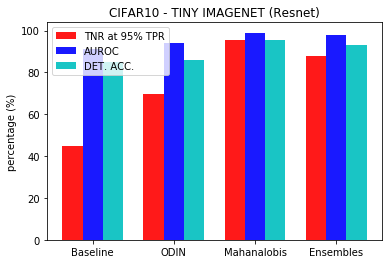

In [16]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (44.7, 69.6, 95.5, 100 * tnr_at_tpr95)
AUROC_ALL = (91.0, 93.9, 99.0, 100 * auroc)
DTACC_ALL = (85.1, 86.0, 95.4, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'CIFAR10 - TINY IMAGENET (Resnet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])

## Experiment 5: CIFAR 100 (IND) vs SVHN on Resnet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [23]:
# load the model
n_classes = 100
model = resnet.ResNet34(num_c = n_classes).to(device)
pre_trained_net = 'models/resnet_cifar100.pth'
# load the model
model.load_state_dict(torch.load(pre_trained_net, map_location = device))

# put model in eval mode
model.eval()

# some extra params
batch_size = 100
layer_sizes_mean = [64, 64, 128, 256, 512, n_classes]
# normalization transform for that model
min_pixel = -2.42906570435
max_pixel = 2.75373125076
norm_trans_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

### Load datasets

Then, we load the IND and OOD datasets

In [22]:
# load In-Distribution (IND) data
# CIFAR 100
trainset = datasets.CIFAR100(root='data', train=True,
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.CIFAR100(root='data', train=False,
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# SVHN
testset = datasets.SVHN(root='data', split='test',
                                       download=True, transform=transform)
ood_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [24]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)







  0%|                                                                                          | 0/500 [00:00<?, ?it/s]





  0%|▏                                                                                 | 1/500 [00:00<05:32,  1.50it/s]





  0%|▎                                                                                 | 2/500 [00:01<05:30,  1.51it/s]





  1%|▍                                                                                 | 3/500 [00:01<05:28,  1.51it/s]





  1%|▋                                                                                 | 4/500 [00:02<05:30,  1.50it/s]





  1%|▊                                                                                 | 5/500 [00:03<05:26,  1.52it/s]





  1%|▉                                                                                 | 6/500 [00:03<05:25,  1.52it/s]





  1%|█▏                                                                                | 7/500 [00:04<05:22,  1.53it/s]

 13%|██████████▌                                                                      | 65/500 [00:42<04:44,  1.53it/s]





 13%|██████████▋                                                                      | 66/500 [00:43<04:41,  1.54it/s]





 13%|██████████▊                                                                      | 67/500 [00:43<04:42,  1.53it/s]





 14%|███████████                                                                      | 68/500 [00:44<04:42,  1.53it/s]





 14%|███████████▏                                                                     | 69/500 [00:45<04:41,  1.53it/s]





 14%|███████████▎                                                                     | 70/500 [00:45<04:42,  1.52it/s]





 14%|███████████▌                                                                     | 71/500 [00:46<04:41,  1.52it/s]





 14%|███████████▋                                                                     | 72/500 [00:47<04:41,  1.52it/s]







 26%|████████████████████▊                                                           | 130/500 [01:25<04:19,  1.43it/s]





 26%|████████████████████▉                                                           | 131/500 [01:26<04:18,  1.43it/s]





 26%|█████████████████████                                                           | 132/500 [01:27<04:17,  1.43it/s]





 27%|█████████████████████▎                                                          | 133/500 [01:28<04:15,  1.44it/s]





 27%|█████████████████████▍                                                          | 134/500 [01:28<04:10,  1.46it/s]





 27%|█████████████████████▌                                                          | 135/500 [01:29<04:05,  1.49it/s]





 27%|█████████████████████▊                                                          | 136/500 [01:29<04:02,  1.50it/s]





 27%|█████████████████████▉                                                          | 137/500 [01:30<03:58,  1.52it/s]







 39%|███████████████████████████████▏                                                | 195/500 [02:08<03:18,  1.53it/s]





 39%|███████████████████████████████▎                                                | 196/500 [02:09<03:17,  1.54it/s]





 39%|███████████████████████████████▌                                                | 197/500 [02:09<03:16,  1.54it/s]





 40%|███████████████████████████████▋                                                | 198/500 [02:10<03:15,  1.54it/s]





 40%|███████████████████████████████▊                                                | 199/500 [02:11<03:14,  1.55it/s]





 40%|████████████████████████████████                                                | 200/500 [02:11<03:14,  1.55it/s]





 40%|████████████████████████████████▏                                               | 201/500 [02:12<03:12,  1.55it/s]





 40%|████████████████████████████████▎                                               | 202/500 [02:12<03:14,  1.53it/s]







 52%|█████████████████████████████████████████▌                                      | 260/500 [02:51<02:36,  1.54it/s]





 52%|█████████████████████████████████████████▊                                      | 261/500 [02:51<02:37,  1.52it/s]





 52%|█████████████████████████████████████████▉                                      | 262/500 [02:52<02:37,  1.51it/s]





 53%|██████████████████████████████████████████                                      | 263/500 [02:53<02:36,  1.51it/s]





 53%|██████████████████████████████████████████▏                                     | 264/500 [02:53<02:36,  1.51it/s]





 53%|██████████████████████████████████████████▍                                     | 265/500 [02:54<02:36,  1.51it/s]





 53%|██████████████████████████████████████████▌                                     | 266/500 [02:55<02:36,  1.49it/s]





 53%|██████████████████████████████████████████▋                                     | 267/500 [02:55<02:35,  1.49it/s]







 65%|████████████████████████████████████████████████████                            | 325/500 [03:34<01:53,  1.55it/s]





 65%|████████████████████████████████████████████████████▏                           | 326/500 [03:35<01:52,  1.54it/s]





 65%|████████████████████████████████████████████████████▎                           | 327/500 [03:35<01:52,  1.54it/s]





 66%|████████████████████████████████████████████████████▍                           | 328/500 [03:36<01:51,  1.55it/s]





 66%|████████████████████████████████████████████████████▋                           | 329/500 [03:36<01:50,  1.55it/s]





 66%|████████████████████████████████████████████████████▊                           | 330/500 [03:37<01:49,  1.55it/s]





 66%|████████████████████████████████████████████████████▉                           | 331/500 [03:38<01:49,  1.55it/s]





 66%|█████████████████████████████████████████████████████                           | 332/500 [03:38<01:48,  1.55it/s]







 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [04:19<01:18,  1.41it/s]





 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [04:19<01:17,  1.41it/s]





 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [04:20<01:16,  1.41it/s]





 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [04:21<01:15,  1.41it/s]





 79%|███████████████████████████████████████████████████████████████                 | 394/500 [04:21<01:15,  1.41it/s]





 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [04:22<01:14,  1.41it/s]





 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [04:23<01:13,  1.42it/s]





 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [04:23<01:12,  1.42it/s]







 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [05:04<00:31,  1.42it/s]





 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [05:05<00:30,  1.42it/s]





 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [05:05<00:30,  1.42it/s]





 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [05:06<00:29,  1.42it/s]





 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [05:07<00:28,  1.42it/s]





 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [05:07<00:28,  1.42it/s]





 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [05:08<00:27,  1.41it/s]





 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [05:09<00:27,  1.40it/s]







  3%|██▌                                                                               | 8/261 [00:05<02:56,  1.43it/s]






  3%|██▊                                                                               | 9/261 [00:06<02:55,  1.44it/s]






  4%|███                                                                              | 10/261 [00:06<02:54,  1.44it/s]

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [25]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)









  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)








 10%|████████▎                                                                          | 1/10 [00:04<00:44,  4.89s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)








 20%|████████████████▌                                                                  | 2/10 [00:10<00:39,  4.99s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning:

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

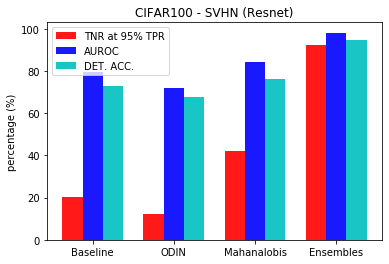

In [26]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (20.3, 12.2, 41.9, 100 * tnr_at_tpr95)
AUROC_ALL = (79.5, 72.0, 84.4, 100 * auroc)
DTACC_ALL = (73.2, 67.7, 76.5, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'CIFAR100 - SVHN (Resnet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])

## Experiment 6: SVHN (IND) vs LSUN on Resnet

### Load model and parameters

First, we load the model, as well as some parameters for preprocessing the data, net layer sizes, etc.

In [27]:
# load the model
n_classes = 10
model = resnet.ResNet34(num_c = n_classes).to(device)
pre_trained_net = 'models/resnet_svhn.pth'
# load the model
model.load_state_dict(torch.load(pre_trained_net, map_location = device))

# put model in eval mode
model.eval()

# some extra params
batch_size = 100
layer_sizes_mean = [64, 64, 128, 256, 512, n_classes]
# normalization transform for that model
min_pixel = -2.42906570435
max_pixel = 2.75373125076
norm_trans_std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

### Load datasets

Then, we load the IND and OOD datasets

In [28]:
# load In-Distribution (IND) data
# SVHN
trainset = datasets.SVHN(root='data', split='train',
                                        download=True, transform=transform)
ind_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = datasets.SVHN(root='data', split='test',
                                       download=True, transform=transform)
ind_test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

# load Out-Of-Distribution (OOD) dataset
# LSUN
ood_test_data = ImageFolder(root='data/LSUN_resize',  transform = transform)

ood_test_loader = torch.utils.data.DataLoader(ood_test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat


### Extract intermediate activations - features

Next, we collect the intermediate layer activations (features) of all datasets. We extract these in the same way as in the Mahanalobis paper (from the same blocks, using channnel-wise averaging, etc. - see paper for the details). Intermediate features are stored in 2D arrays, and also the predictions results (pred vs label) are also extracted. We also have functions tp extract the needed layer features form these arrays later.

In [29]:
# collect intermediate layer activations (features) on data

# IND training features
A, Ares = exp_utils.collectActivMah(ind_train_loader, model, layer_sizes_mean)

# IND test features
B, Bres = exp_utils.collectActivMah(ind_test_loader, model, layer_sizes_mean, 1000)

# OOD test features
C, Cres = exp_utils.collectActivMah(ood_test_loader, model, layer_sizes_mean, 1000)









  0%|                                                                                          | 0/733 [00:00<?, ?it/s]







  0%|                                                                                  | 1/733 [00:00<07:58,  1.53it/s]







  0%|▏                                                                                 | 2/733 [00:01<08:00,  1.52it/s]







  0%|▎                                                                                 | 3/733 [00:01<08:03,  1.51it/s]







  1%|▍                                                                                 | 4/733 [00:02<07:59,  1.52it/s]







  1%|▌                                                                                 | 5/733 [00:03<07:55,  1.53it/s]







  1%|▋                                                                                 | 6/733 [00:03<07:56,  1.53it/s]







  1%|▊                                                                                 | 7/733 [00:04<0

  9%|███████                                                                          | 64/733 [00:41<07:19,  1.52it/s]







  9%|███████▏                                                                         | 65/733 [00:42<07:18,  1.52it/s]







  9%|███████▎                                                                         | 66/733 [00:43<07:16,  1.53it/s]







  9%|███████▍                                                                         | 67/733 [00:43<07:18,  1.52it/s]







  9%|███████▌                                                                         | 68/733 [00:44<07:16,  1.52it/s]







  9%|███████▌                                                                         | 69/733 [00:45<07:12,  1.54it/s]







 10%|███████▋                                                                         | 70/733 [00:45<07:11,  1.54it/s]







 10%|███████▊                                                                         | 71/733 [00:46<07:08,  1

 17%|█████████████▉                                                                  | 128/733 [01:23<06:32,  1.54it/s]







 18%|██████████████                                                                  | 129/733 [01:24<06:32,  1.54it/s]







 18%|██████████████▏                                                                 | 130/733 [01:24<06:31,  1.54it/s]







 18%|██████████████▎                                                                 | 131/733 [01:25<06:28,  1.55it/s]







 18%|██████████████▍                                                                 | 132/733 [01:25<06:28,  1.55it/s]







 18%|██████████████▌                                                                 | 133/733 [01:26<06:26,  1.55it/s]







 18%|██████████████▌                                                                 | 134/733 [01:27<06:26,  1.55it/s]







 18%|██████████████▋                                                                 | 135/733 [01:27<06:24,  1

 26%|████████████████████▉                                                           | 192/733 [02:05<05:58,  1.51it/s]







 26%|█████████████████████                                                           | 193/733 [02:06<05:59,  1.50it/s]







 26%|█████████████████████▏                                                          | 194/733 [02:06<05:55,  1.52it/s]







 27%|█████████████████████▎                                                          | 195/733 [02:07<05:53,  1.52it/s]







 27%|█████████████████████▍                                                          | 196/733 [02:07<05:49,  1.54it/s]







 27%|█████████████████████▌                                                          | 197/733 [02:08<05:48,  1.54it/s]







 27%|█████████████████████▌                                                          | 198/733 [02:09<05:46,  1.55it/s]







 27%|█████████████████████▋                                                          | 199/733 [02:09<05:45,  1

 35%|███████████████████████████▉                                                    | 256/733 [02:46<05:11,  1.53it/s]







 35%|████████████████████████████                                                    | 257/733 [02:47<05:08,  1.54it/s]







 35%|████████████████████████████▏                                                   | 258/733 [02:48<05:07,  1.54it/s]







 35%|████████████████████████████▎                                                   | 259/733 [02:48<05:08,  1.54it/s]







 35%|████████████████████████████▍                                                   | 260/733 [02:49<05:07,  1.54it/s]







 36%|████████████████████████████▍                                                   | 261/733 [02:49<05:05,  1.55it/s]







 36%|████████████████████████████▌                                                   | 262/733 [02:50<05:06,  1.53it/s]







 36%|████████████████████████████▋                                                   | 263/733 [02:51<05:06,  1

 44%|██████████████████████████████████▉                                             | 320/733 [03:28<04:27,  1.54it/s]







 44%|███████████████████████████████████                                             | 321/733 [03:29<04:27,  1.54it/s]







 44%|███████████████████████████████████▏                                            | 322/733 [03:29<04:27,  1.54it/s]







 44%|███████████████████████████████████▎                                            | 323/733 [03:30<04:26,  1.54it/s]







 44%|███████████████████████████████████▎                                            | 324/733 [03:30<04:26,  1.54it/s]







 44%|███████████████████████████████████▍                                            | 325/733 [03:31<04:25,  1.54it/s]







 44%|███████████████████████████████████▌                                            | 326/733 [03:32<04:23,  1.55it/s]







 45%|███████████████████████████████████▋                                            | 327/733 [03:32<04:22,  1

 52%|█████████████████████████████████████████▉                                      | 384/733 [04:09<03:46,  1.54it/s]







 53%|██████████████████████████████████████████                                      | 385/733 [04:10<03:47,  1.53it/s]







 53%|██████████████████████████████████████████▏                                     | 386/733 [04:11<03:45,  1.54it/s]







 53%|██████████████████████████████████████████▏                                     | 387/733 [04:11<03:44,  1.54it/s]







 53%|██████████████████████████████████████████▎                                     | 388/733 [04:12<03:44,  1.54it/s]







 53%|██████████████████████████████████████████▍                                     | 389/733 [04:13<03:43,  1.54it/s]







 53%|██████████████████████████████████████████▌                                     | 390/733 [04:13<03:43,  1.53it/s]







 53%|██████████████████████████████████████████▋                                     | 391/733 [04:14<03:42,  1

 61%|████████████████████████████████████████████████▉                               | 448/733 [04:51<03:04,  1.54it/s]







 61%|█████████████████████████████████████████████████                               | 449/733 [04:52<03:05,  1.53it/s]







 61%|█████████████████████████████████████████████████                               | 450/733 [04:53<03:03,  1.54it/s]







 62%|█████████████████████████████████████████████████▏                              | 451/733 [04:53<03:03,  1.54it/s]







 62%|█████████████████████████████████████████████████▎                              | 452/733 [04:54<03:02,  1.54it/s]







 62%|█████████████████████████████████████████████████▍                              | 453/733 [04:55<03:01,  1.54it/s]







 62%|█████████████████████████████████████████████████▌                              | 454/733 [04:55<03:01,  1.54it/s]







 62%|█████████████████████████████████████████████████▋                              | 455/733 [04:56<02:59,  1

 70%|███████████████████████████████████████████████████████▉                        | 512/733 [05:33<02:23,  1.54it/s]







 70%|███████████████████████████████████████████████████████▉                        | 513/733 [05:34<02:22,  1.54it/s]







 70%|████████████████████████████████████████████████████████                        | 514/733 [05:34<02:21,  1.55it/s]







 70%|████████████████████████████████████████████████████████▏                       | 515/733 [05:35<02:21,  1.54it/s]







 70%|████████████████████████████████████████████████████████▎                       | 516/733 [05:35<02:20,  1.54it/s]







 71%|████████████████████████████████████████████████████████▍                       | 517/733 [05:36<02:19,  1.54it/s]







 71%|████████████████████████████████████████████████████████▌                       | 518/733 [05:37<02:19,  1.54it/s]







 71%|████████████████████████████████████████████████████████▋                       | 519/733 [05:37<02:18,  1

 79%|██████████████████████████████████████████████████████████████▊                 | 576/733 [06:15<01:42,  1.54it/s]







 79%|██████████████████████████████████████████████████████████████▉                 | 577/733 [06:15<01:42,  1.53it/s]







 79%|███████████████████████████████████████████████████████████████                 | 578/733 [06:16<01:40,  1.54it/s]







 79%|███████████████████████████████████████████████████████████████▏                | 579/733 [06:17<01:40,  1.54it/s]







 79%|███████████████████████████████████████████████████████████████▎                | 580/733 [06:17<01:39,  1.54it/s]







 79%|███████████████████████████████████████████████████████████████▍                | 581/733 [06:18<01:38,  1.54it/s]







 79%|███████████████████████████████████████████████████████████████▌                | 582/733 [06:18<01:37,  1.55it/s]







 80%|███████████████████████████████████████████████████████████████▋                | 583/733 [06:19<01:37,  1

 87%|█████████████████████████████████████████████████████████████████████▊          | 640/733 [06:56<01:00,  1.53it/s]







 87%|█████████████████████████████████████████████████████████████████████▉          | 641/733 [06:57<01:00,  1.53it/s]







 88%|██████████████████████████████████████████████████████████████████████          | 642/733 [06:58<00:59,  1.52it/s]







 88%|██████████████████████████████████████████████████████████████████████▏         | 643/733 [06:58<00:58,  1.53it/s]







 88%|██████████████████████████████████████████████████████████████████████▎         | 644/733 [06:59<00:57,  1.54it/s]







 88%|██████████████████████████████████████████████████████████████████████▍         | 645/733 [07:00<00:58,  1.51it/s]







 88%|██████████████████████████████████████████████████████████████████████▌         | 646/733 [07:00<00:57,  1.51it/s]







 88%|██████████████████████████████████████████████████████████████████████▌         | 647/733 [07:01<00:57,  1

 96%|████████████████████████████████████████████████████████████████████████████▊   | 704/733 [07:38<00:18,  1.54it/s]







 96%|████████████████████████████████████████████████████████████████████████████▉   | 705/733 [07:39<00:18,  1.54it/s]







 96%|█████████████████████████████████████████████████████████████████████████████   | 706/733 [07:39<00:17,  1.55it/s]







 96%|█████████████████████████████████████████████████████████████████████████████▏  | 707/733 [07:40<00:16,  1.55it/s]







 97%|█████████████████████████████████████████████████████████████████████████████▎  | 708/733 [07:41<00:16,  1.54it/s]







 97%|█████████████████████████████████████████████████████████████████████████████▍  | 709/733 [07:41<00:15,  1.54it/s]







 97%|█████████████████████████████████████████████████████████████████████████████▍  | 710/733 [07:42<00:14,  1.54it/s]







 97%|█████████████████████████████████████████████████████████████████████████████▌  | 711/733 [07:42<00:14,  1

### Train ensembles on selected intermediate features

After intermediate features are obtained, we can then train an esemble on them, as described above. We train the esnembles on the training data, and then evaluate uncertainties on the test datasets (IND and OOD).

In [30]:
# train an ensemble of 10 single layer nets
lay = 3 # intermediate layer to build on top
# base classifier
clf_base = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, hidden_layer_sizes=(), max_iter=10))
n_clfs = 10 # number of ensemble classifiers
portion = 0.7 # random data portion to train each member

# train all classifiers, get results (pred classes and probabilities)
Ypred_ind, Ppred_ind, Ypred_ood, Ppred_ood = ens_utils.do_all_clf(clf_base, A, Ares, B, Bres, C, Cres, n_classes, lay, layer_sizes_mean, n_clfs, portion)










  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)









 10%|████████▎                                                                          | 1/10 [00:03<00:31,  3.45s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)









 20%|████████████████▌                                                                  | 2/10 [00:06<00:27,  3.40s/it]C:\Users\admin\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarni

### Evaluate Performance

After training is finished, we can evaluate the uncertainty estimation performance.

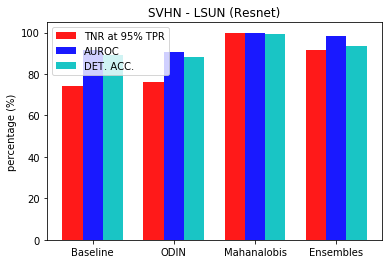

In [31]:
# measure performance
# get entropy scores of IND and OOD
known = ens_utils.entropy_scores(Bres, Ppred_ind)
novel = ens_utils.entropy_scores(Cres, Ppred_ood)

# measure perf
tnr_at_tpr95, auroc, dtacc, _, _ = metrics.calc_metrics(known, novel)

# results of all methods (for plotting)
TNR_AT_95_ALL = (74.3, 76.3, 99.9, 100 * tnr_at_tpr95)
AUROC_ALL = (91.6, 90.7, 99.9, 100 * auroc)
DTACC_ALL = (89.0, 88.2, 99.5, 100 * dtacc)

# plot bar chart
myplots.make_barplot([TNR_AT_95_ALL, AUROC_ALL, DTACC_ALL], 
                     'SVHN - LSUN (Resnet)', ['Baseline', 'ODIN', 'Mahanalobis', 'Ensembles'], 
                     ['TNR at 95% TPR', 'AUROC', 'DET. ACC.'])